## Import Libraries

In [12]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    BertTokenizerFast,
    BertTokenizer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    pipeline,
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
print("Libraries imported")

Libraries imported


## Set fixed seed

In [13]:
# ============
# Reproducibility
# ============
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Configuration

In [14]:
# ============
# Configuration
# ============
MAX_LEN = 256
BATCH_SIZE = 64
EPOCHS = 5
PATIENCE = 2  # For early stopping


distilmBERT_base = "distilbert/distilbert-base-multilingual-cased"
distilmBERT_fine_tuned = "/kaggle/input/distil_mbert_for_paper/pytorch/default/1"

RuBERT_base = "DeepPavlov/rubert-base-cased"
RuBERT_fine_tuned = "/kaggle/input/rubert_for_paper/pytorch/default/1"

mBERT_base = "google-bert/bert-base-multilingual-cased"
mBERT_fine_tuned = "/kaggle/input/mbert_for_paper/pytorch/default/1"

# Output directory for saving best models
OUTPUT_DIR = "./saved_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Data Preprocessing

New DF: (5568, 2)
Preprocessed DF: (5487, 2)
                                                   text  sentiment
1527  In the building and home improvement trade , s...          0
33    Siemens Energy has not yet provided the Russia...          0
8     В первоначальной версии материала говорилось с...          1
3823  The subsidiary will be responsible for filter ...          1
936   Стать операторами рекламных данных, которые с ...          2
3939  The Company operates through four principal di...          1
3747  Годовой чистый объем продаж подразделения сост...          1
3245          Productional situation has now improved .          2
1677  The selling consortium includes funds managed ...          1
3595  По завершении продажи Proha получит около 12,7...          1


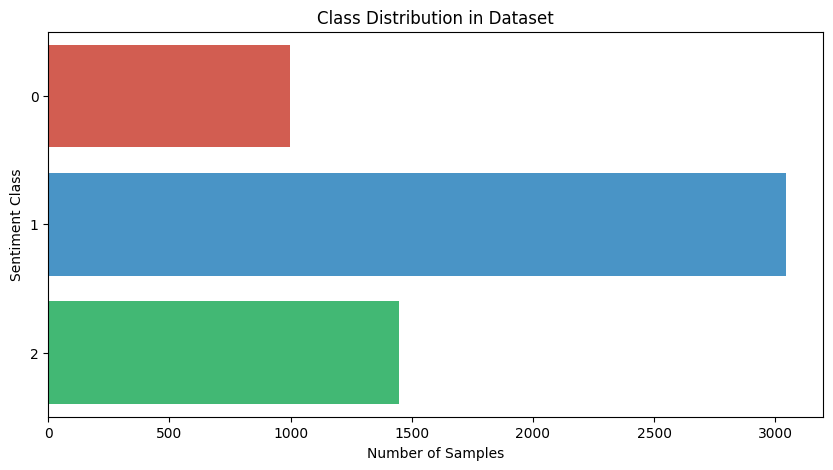

In [15]:
# ============
# Data Loading & Preprocessing
# ============
df1 = pd.read_csv('/kaggle/input/summary/summary.csv')
df2 = pd.read_csv('/kaggle/input/english-russian-financial-phrasebank/english_russian_financial_phrasebank.csv')

# Drop unused columns
if 'sentence_length' in df2.columns:
    df2.drop(columns=['sentence_length'], axis=1, inplace=True)

# Rename columns for consistency
df1.rename(columns={"summary": "text"}, inplace=True)
df2.rename(columns={"sentence": "text"}, inplace=True)

# Combine the datasets
df = pd.concat([df1, df2], ignore_index=True)
print(f"New DF: {df.shape}")

# Drop duplicates and NaNs
df.drop_duplicates(subset='text', keep='first', inplace=True)
df.dropna(subset=['text', 'sentiment'], inplace=True)

# Map sentiment labels to numbers
df['sentiment'] = df['sentiment'].map({"positive": 2, "neutral": 1, "negative": 0})
print(f"Preprocessed DF: {df.shape}")
print(df.sample(10))
# ============
# Data Visualization
# ============
def plot_class_distribution(dataframe):
    plt.figure(figsize=(10, 5))
    counts = dataframe['sentiment'].value_counts().reset_index()
    counts.columns = ['sentiment', 'count']
    sns.barplot(data=counts, x='count', y='sentiment',
                palette=['#e74c3c', '#3498db', '#2ecc71'], orient='h')
    plt.title("Class Distribution in Dataset")
    plt.xlabel("Number of Samples")
    plt.ylabel("Sentiment Class")
    plt.savefig("Class_Distribution_in_Dataset.png")
    plt.show()

plot_class_distribution(df)

In [16]:
# ============
# Dataset Splitting
# ============
train_df, test_df = train_test_split(
    df, test_size=0.2,
    stratify=df['sentiment'],
    random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.125,  # 80-10-10 split
    stratify=train_df['sentiment'],
    random_state=SEED
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 3840
Validation samples: 549
Testing samples: 1098


In [17]:
# ============
# Custom Dataset
# ============
class FinancialSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['sentiment']
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


## Setting Model parameters and hyperparameters 

In [18]:
# ============
# Model Freezing Function
# ============
def freeze_layers(model, num_layers):
    """
    Freeze all parameters except embeddings, the last `num_layers` transformer layers,
    and the classification head.
    Supports both BERT and DistilBERT models.
    """
    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze embeddings and transformer layers if available
    if hasattr(model, 'bert'):
        for param in model.bert.embeddings.parameters():
            param.requires_grad = True
        # Unfreeze the last num_layers transformer layers
        for layer in model.bert.encoder.layer[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True
    elif hasattr(model, 'distilbert'):
        for param in model.distilbert.embeddings.parameters():
            param.requires_grad = True
        # For DistilBERT, transformer layers are in model.distilbert.transformer.layer
        for layer in model.distilbert.transformer.layer[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True
    else:
        print("Warning: Unrecognized model architecture for freezing layers.")

    # Unfreeze the classifier head (or score layer)
    if hasattr(model, 'classifier'):
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif hasattr(model, 'score'):
        for param in model.score.parameters():
            param.requires_grad = True
    else:
        print("Warning: No classifier head found to unfreeze.")

    return model

In [19]:
# ============
# Model Initialization
# ============
def initialize_model(model_name, num_labels, num_layers):
    """
    Load the tokenizer and model from a given name or directory.
    Also computes class weights for the training data.
    """
    # If model_name is a directory, ensure that the local tokenizer is loaded
    if os.path.isdir(model_name):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    ).to(device)

    # Freeze layers as per our strategy
    model = freeze_layers(model, num_layers)
    model.to(device)
    # Use 2 GPUs if available
    if torch.cuda.device_count() >= 2:
        print(f"Using 2 GPUs: {torch.cuda.device_count()} detected. Wrapping model in DataParallel using GPUs 0 and 1.")
        model = torch.nn.DataParallel(model, device_ids=[0, 1])

    # Compute class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_df['sentiment']),
        y=train_df['sentiment']
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    return tokenizer, model, class_weights

## Trainer Class

In [20]:
# ============
# Trainer Class
# ============
class Trainer:
    def __init__(self, model, train_loader, val_loader, class_weights, epochs, patience, name):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.patience = patience
        self.name = name

        self.criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
        
        total_steps = len(train_loader) * epochs
        warmup_steps = int(0.1 * total_steps)
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        self.best_val_loss = float('inf')
        self.early_stop_counter = 0
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def train_epoch(self):
        self.model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for batch in self.train_loader:
            self.optimizer.zero_grad()

            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = self.model(**inputs)
            loss = self.criterion(outputs.logits, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

            epoch_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        return epoch_loss / len(self.train_loader), correct / total

    def evaluate(self, loader):
        self.model.eval()
        epoch_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                outputs = self.model(**inputs)
                loss = self.criterion(outputs.logits, labels)

                epoch_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct / total
        report = classification_report(
            all_labels, all_preds,
            target_names=['negative', 'neutral', 'positive'],
            output_dict=True,
            zero_division=0
        )
        # Include overall accuracy in the report for later comparison
        report['accuracy'] = accuracy
        return epoch_loss / len(loader), accuracy, report

    def run_training(self):
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc, val_report = self.evaluate(self.val_loader)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)

            print(f"\nEpoch {epoch + 1}/{self.epochs}")
            print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
            print("Val Classification Report:")
            print(pd.DataFrame(val_report).transpose().round(4))

            # Early stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.early_stop_counter = 0
                model_save_path = os.path.join(OUTPUT_DIR, f"best_{self.name}_model.pth")
                torch.save(self.model.state_dict(), model_save_path)
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break


In [21]:
# ============
# Experiment Runner
# ============
def run_experiment(model_name, epochs, patience, name, num_labels, num_layers, is_baseline=False):
    tokenizer, model, class_weights = initialize_model(model_name, num_labels, num_layers)

    # Create datasets
    train_dataset = FinancialSentimentDataset(train_df, tokenizer, MAX_LEN)
    val_dataset = FinancialSentimentDataset(val_df, tokenizer, MAX_LEN)
    test_dataset = FinancialSentimentDataset(test_df, tokenizer, MAX_LEN)

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Train model
    trainer = Trainer(model, train_loader, val_loader, class_weights, epochs, patience, name)
    trainer.run_training()

    # Load the best model for testing
    best_model_path = os.path.join(OUTPUT_DIR, f"best_{name}_model.pth")
    model.load_state_dict(torch.load(best_model_path))
    test_loss, test_acc, test_report = trainer.evaluate(test_loader)

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label='Train')
    plt.plot(trainer.val_losses, label='Validation')
    plt.title('Training/Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(trainer.train_accs, label='Train')
    plt.plot(trainer.val_accs, label='Validation')
    plt.title('Training/Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plot_filename = f"{'baseline' if is_baseline else 'finetuned'}_training_curves.png"
    plt.savefig(plot_filename)
    plt.show()

    return test_report

## Comparison Function

In [22]:
# ============
# Comparison Function
# ============
def print_model_comparison(*reports, model_names):
    """
    Print a formatted comparison table of classification reports.
    """
    if len(reports) != len(model_names):
        raise ValueError("Number of reports must match number of model names")

    metrics = ['precision', 'recall', 'f1-score']
    classes = ['negative', 'neutral', 'positive']
    avg_types = ['macro avg', 'weighted avg']
    col_width = 14
    sep = "|"

    def print_divider():
        print("-" * (10 + (col_width + 1) * len(model_names)))

    def print_header():
        header = f"{'Class':<10}{sep}" + sep.join(f"{name:<{col_width}}" for name in model_names)
        print(header)

    for metric in metrics:
        print(f"\n{metric.upper()} COMPARISON")
        print_divider()
        print_header()
        print_divider()

        # For each class
        for cls in classes:
            row = f"{cls:<10}{sep}"
            for report in reports:
                row += f"{report[cls][metric]:.4f}".center(col_width) + sep
            print(row)
        print_divider()
        for avg in avg_types:
            row = f"{avg:<10}{sep}"
            for report in reports:
                row += f"{report[avg][metric]:.4f}".center(col_width) + sep
            print(row)

    # Print overall accuracy
    print(f"\nACCURACY COMPARISON")
    print_divider()
    print_header()
    print_divider()
    acc_row = f"{'':<10}{sep}"
    for report in reports:
        acc_row += f"{report['accuracy']:.4f}".center(col_width) + sep
    print(acc_row)
    print_divider()


## Training


=== Base distil mBERT Model Evaluation ===


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs: 2 detected. Wrapping model in DataParallel using GPUs 0 and 1.

Epoch 1/5
Train Loss: 1.0482 | Acc: 0.4437
Val Loss: 0.8698 | Acc: 0.6831
Val Classification Report:
              precision  recall  f1-score   support
negative         0.4308  0.5600    0.4870  100.0000
neutral          0.8312  0.8393    0.8352  305.0000
positive         0.5676  0.4375    0.4941  144.0000
accuracy         0.6831  0.6831    0.6831    0.6831
macro avg        0.6098  0.6123    0.6054  549.0000
weighted avg     0.6891  0.6831    0.6823  549.0000

Epoch 2/5
Train Loss: 0.7379 | Acc: 0.7214
Val Loss: 0.6611 | Acc: 0.7541
Val Classification Report:
              precision  recall  f1-score   support
negative         0.5132  0.7800    0.6190  100.0000
neutral          0.8966  0.8525    0.8739  305.0000
positive         0.7103  0.5278    0.6056  144.0000
accuracy         0.7541  0.7541    0.7541    0.7541
macro avg        0.7067  0.7201    0.6995  549.0000
weighted avg     0.7779  0.7541    0.7571  

<ipython-input-21-8869a3a140c9>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


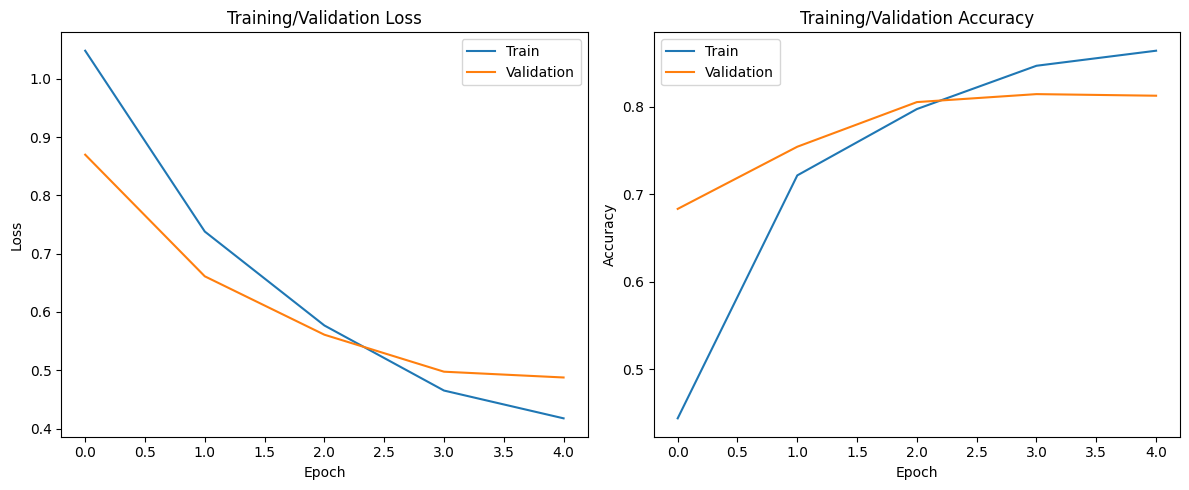


=== Fine Tuned distil mBERT Model Evaluation ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/distil_mbert_for_paper/pytorch/default/1 and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs: 2 detected. Wrapping model in DataParallel using GPUs 0 and 1.

Epoch 1/5
Train Loss: 1.0367 | Acc: 0.5135
Val Loss: 0.8641 | Acc: 0.6776
Val Classification Report:
              precision  recall  f1-score   support
negative         0.4407  0.2600    0.3270  100.0000
neutral          0.8428  0.8262    0.8344  305.0000
positive         0.4921  0.6528    0.5612  144.0000
accuracy         0.6776  0.6776    0.6776    0.6776
macro avg        0.5919  0.5797    0.5742  549.0000
weighted avg     0.6776  0.6776    0.6703  549.0000

Epoch 2/5
Train Loss: 0.7457 | Acc: 0.7229
Val Loss: 0.6779 | Acc: 0.7413
Val Classification Report:
              precision  recall  f1-score   support
negative         0.5092  0.8300    0.6312  100.0000
neutral          0.9078  0.8393    0.8722  305.0000
positive         0.6538  0.4722    0.5484  144.0000
accuracy         0.7413  0.7413    0.7413    0.7413
macro avg        0.6903  0.7139    0.6839  549.0000
weighted avg     0.7686  0.7413    0.7434  

<ipython-input-21-8869a3a140c9>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


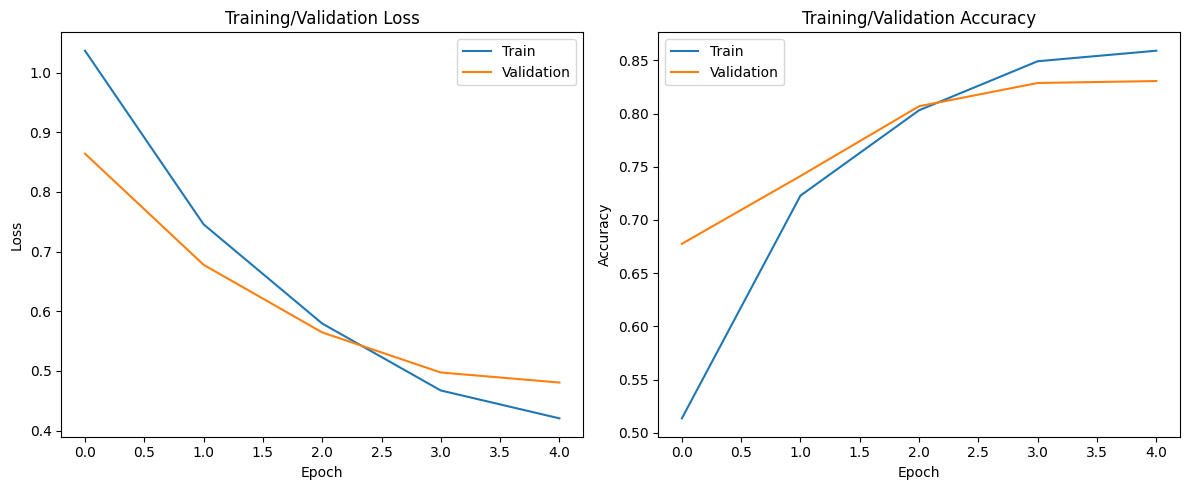


=== Base RuBERT Model Evaluation ===


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs: 2 detected. Wrapping model in DataParallel using GPUs 0 and 1.

Epoch 1/5
Train Loss: 1.0648 | Acc: 0.3867
Val Loss: 0.9187 | Acc: 0.6612
Val Classification Report:
              precision  recall  f1-score   support
negative         0.3900  0.3900    0.3900  100.0000
neutral          0.8385  0.8000    0.8188  305.0000
positive         0.5063  0.5556    0.5298  144.0000
accuracy         0.6612  0.6612    0.6612    0.6612
macro avg        0.5783  0.5819    0.5795  549.0000
weighted avg     0.6697  0.6612    0.6649  549.0000

Epoch 2/5
Train Loss: 0.8373 | Acc: 0.6669
Val Loss: 0.7765 | Acc: 0.7031
Val Classification Report:
              precision  recall  f1-score   support
negative         0.4818  0.5300    0.5048  100.0000
neutral          0.8842  0.8262    0.8542  305.0000
positive         0.5260  0.5625    0.5436  144.0000
accuracy         0.7031  0.7031    0.7031    0.7031
macro avg        0.6307  0.6396    0.6342  549.0000
weighted avg     0.7170  0.7031    0.7091  

<ipython-input-21-8869a3a140c9>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


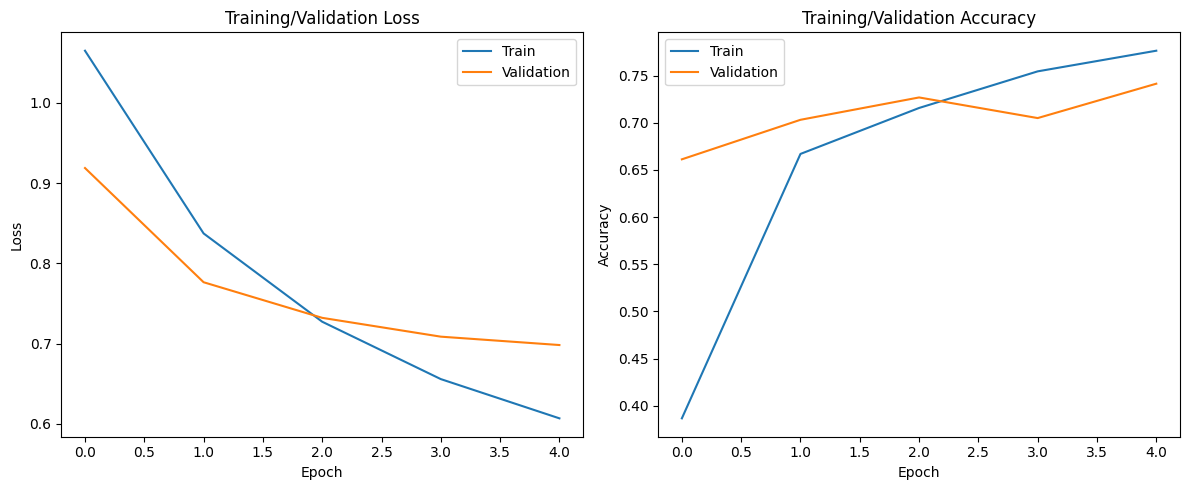


=== Fine Tuned RuBERT Model Evaluation ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/rubert_for_paper/pytorch/default/1 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs: 2 detected. Wrapping model in DataParallel using GPUs 0 and 1.

Epoch 1/5
Train Loss: 1.0589 | Acc: 0.4133
Val Loss: 0.9138 | Acc: 0.6758
Val Classification Report:
              precision  recall  f1-score   support
negative         0.5676  0.2100    0.3066  100.0000
neutral          0.7922  0.8623    0.8257  305.0000
positive         0.4833  0.6042    0.5370  144.0000
accuracy         0.6758  0.6758    0.6758    0.6758
macro avg        0.6144  0.5588    0.5565  549.0000
weighted avg     0.6703  0.6758    0.6555  549.0000

Epoch 2/5
Train Loss: 0.7660 | Acc: 0.7203
Val Loss: 0.6206 | Acc: 0.7632
Val Classification Report:
              precision  recall  f1-score   support
negative         0.5461  0.8300    0.6587  100.0000
neutral          0.8893  0.8689    0.8789  305.0000
positive         0.7172  0.4931    0.5844  144.0000
accuracy         0.7632  0.7632    0.7632    0.7632
macro avg        0.7175  0.7306    0.7073  549.0000
weighted avg     0.7816  0.7632    0.7616  

<ipython-input-21-8869a3a140c9>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


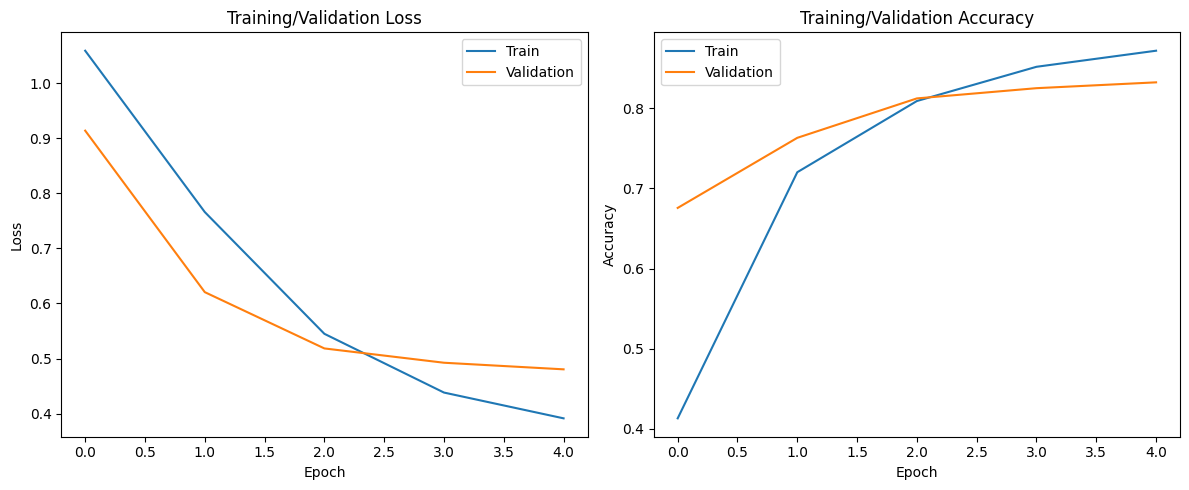


=== Base mBERT Model Evaluation ===


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs: 2 detected. Wrapping model in DataParallel using GPUs 0 and 1.

Epoch 1/5
Train Loss: 1.0518 | Acc: 0.4477
Val Loss: 0.8699 | Acc: 0.6867
Val Classification Report:
              precision  recall  f1-score   support
negative         0.4865  0.3600    0.4138  100.0000
neutral          0.8519  0.8295    0.8405  305.0000
positive         0.4944  0.6111    0.5466  144.0000
accuracy         0.6867  0.6867    0.6867    0.6867
macro avg        0.6109  0.6002    0.6003  549.0000
weighted avg     0.6915  0.6867    0.6857  549.0000

Epoch 2/5
Train Loss: 0.7709 | Acc: 0.6964
Val Loss: 0.6885 | Acc: 0.7395
Val Classification Report:
              precision  recall  f1-score   support
negative         0.4965  0.7100    0.5844  100.0000
neutral          0.9081  0.8426    0.8741  305.0000
positive         0.6341  0.5417    0.5843  144.0000
accuracy         0.7395  0.7395    0.7395    0.7395
macro avg        0.6796  0.6981    0.6809  549.0000
weighted avg     0.7613  0.7395    0.7453  

<ipython-input-21-8869a3a140c9>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


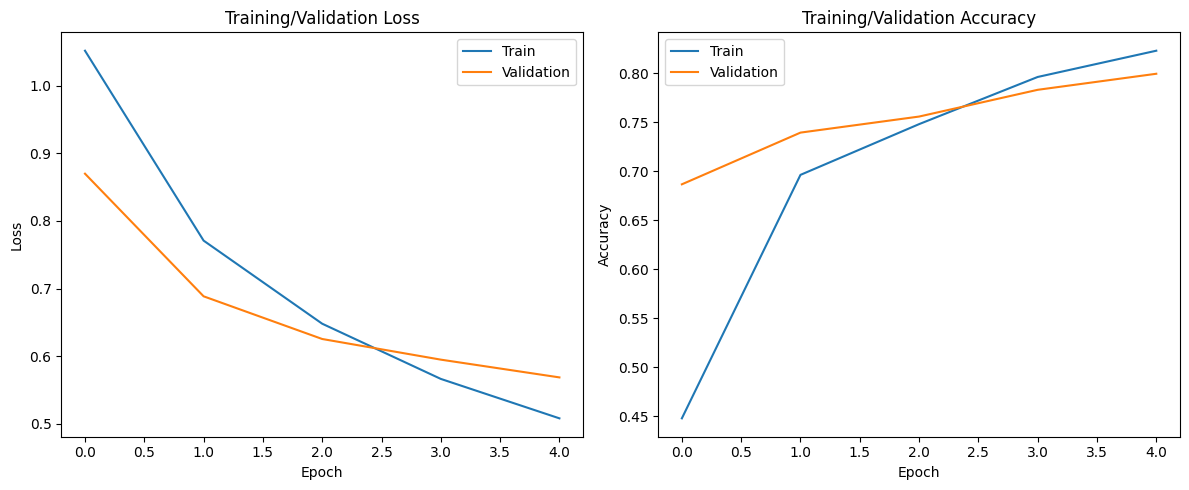


=== Fine Tuned mBERT Model Evaluation ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/mbert_for_paper/pytorch/default/1 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs: 2 detected. Wrapping model in DataParallel using GPUs 0 and 1.

Epoch 1/5
Train Loss: 1.0576 | Acc: 0.4651
Val Loss: 0.8708 | Acc: 0.6922
Val Classification Report:
              precision  recall  f1-score   support
negative         0.5256  0.4100    0.4607  100.0000
neutral          0.8852  0.7836    0.8313  305.0000
positive         0.4975  0.6944    0.5797  144.0000
accuracy         0.6922  0.6922    0.6922    0.6922
macro avg        0.6361  0.6294    0.6239  549.0000
weighted avg     0.7180  0.6922    0.6978  549.0000

Epoch 2/5
Train Loss: 0.7023 | Acc: 0.7419
Val Loss: 0.5591 | Acc: 0.8015
Val Classification Report:
              precision  recall  f1-score   support
negative         0.6311  0.7700    0.6937  100.0000
neutral          0.9263  0.8656    0.8949  305.0000
positive         0.6972  0.6875    0.6923  144.0000
accuracy         0.8015  0.8015    0.8015    0.8015
macro avg        0.7515  0.7744    0.7603  549.0000
weighted avg     0.8125  0.8015    0.8051  

<ipython-input-21-8869a3a140c9>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


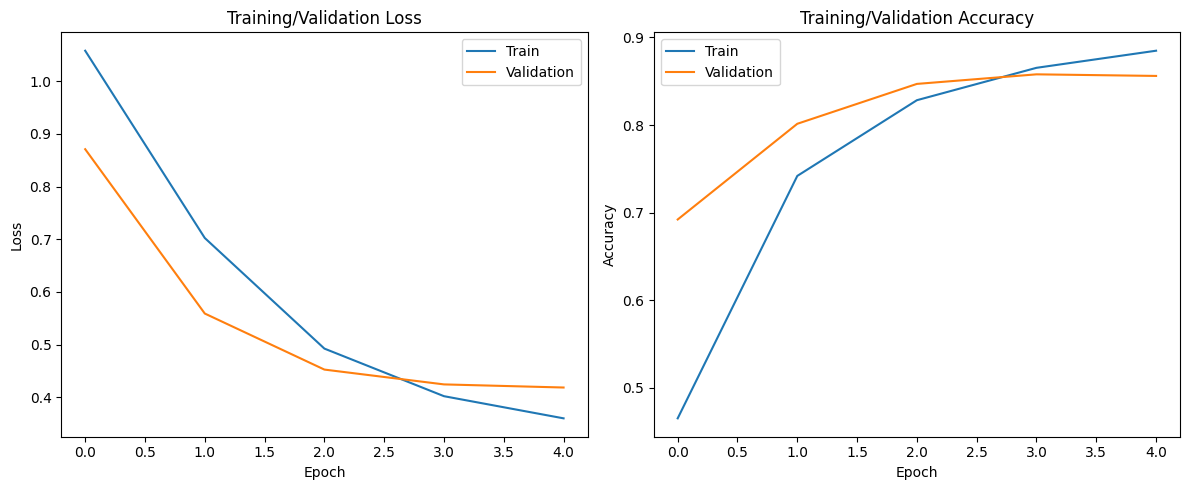

In [23]:
# ============
# Run Experiments
# ============

print("\n=== Base distil mBERT Model Evaluation ===")
Base_distil_mBERT_report = run_experiment(
    distilmBERT_base, EPOCHS, PATIENCE, "BasedistilmBERT", num_labels=3, num_layers=1, is_baseline=True
)
print("\n=== Fine Tuned distil mBERT Model Evaluation ===")
FineTuned_distil_mBERT_report = run_experiment(
    distilmBERT_fine_tuned, EPOCHS, PATIENCE, "FineTuneddistilmBERT", num_labels=3, num_layers=1, is_baseline=False
)

print("\n=== Base RuBERT Model Evaluation ===")
BaseRuBERT_report = run_experiment(
    RuBERT_base, EPOCHS, PATIENCE, "BaseRuBERT", num_labels=3, num_layers=1, is_baseline=True
)

print("\n=== Fine Tuned RuBERT Model Evaluation ===")
FineTunedRuBERT_report = run_experiment(
    RuBERT_fine_tuned, EPOCHS, PATIENCE, "FineTunedRuBERT", num_labels=3, num_layers=1, is_baseline=False
)

print("\n=== Base mBERT Model Evaluation ===")
BasemBERT_report = run_experiment(
    mBERT_base, EPOCHS, PATIENCE, "BasemBERT", num_labels=3, num_layers=1, is_baseline=True
)

print("\n=== Fine Tuned mBERT Model Evaluation ===")
FineTunedmBERT_report = run_experiment(
    mBERT_fine_tuned, EPOCHS, PATIENCE, "FineTunedmBERT", num_labels=3, num_layers=1, is_baseline=False
)

## Results

In [24]:
# ============
# Model Comparison
# ============
print_model_comparison(
    Base_distil_mBERT_report,
    FineTuned_distil_mBERT_report,
    BaseRuBERT_report,
    FineTunedRuBERT_report,
    BasemBERT_report,
    FineTunedmBERT_report,
    model_names=['Base distil-mBERT', 'Fine-tuned distil-mBERT', 'Base RuBERT', 'Fine-tuned RuBERT', 'Base mBERT', 'Fine-tuned mBERT']
)


PRECISION COMPARISON
----------------------------------------------------------------------------------------------------
Class     |Base distil-mBERT|Fine-tuned distil-mBERT|Base RuBERT   |Fine-tuned RuBERT|Base mBERT    |Fine-tuned mBERT
----------------------------------------------------------------------------------------------------
negative  |    0.6557    |    0.6577    |    0.4771    |    0.7025    |    0.5743    |    0.6885    |
neutral   |    0.9241    |    0.9088    |    0.9028    |    0.9195    |    0.9059    |    0.9287    |
positive  |    0.7375    |    0.7599    |    0.6195    |    0.7643    |    0.7155    |    0.8159    |
----------------------------------------------------------------------------------------------------
macro avg |    0.7724    |    0.7754    |    0.6665    |    0.7954    |    0.7319    |    0.8110    |
weighted avg|    0.8262    |    0.8239    |    0.7508    |    0.8392    |    0.7955    |    0.8554    |

RECALL COMPARISON
--------------------------